In [16]:
import functions as f
import pandas as pd
import matplotlib.pyplot as plt



# TASK1

In [17]:
start_time = "2025-09-21T21:00:00Z"
end_time   = "2025-09-22T21:05:00Z"

df_afrr = f.request_data(
    report_id="activations_afrr",
    start_date=start_time,
    end_date=end_time,
    value_name="afrr_activation"
)

df_imb = f.request_data(
    report_id="imbalance_volumes_v2",
    start_date=start_time,
    end_date=end_time,
    value_name="imbalance"
)

df_afrr.head(5)


,timestamp,afrr_activation
0,2025-09-21 21:00:00+00:00,0.002
1,2025-09-21 21:02:30+00:00,1.570
2,2025-09-21 21:05:00+00:00,0.009
3,2025-09-21 21:07:30+00:00,0.891
4,2025-09-21 21:10:00+00:00,0.000


In [18]:
df_imb.head(5)

,timestamp,imbalance
0,2025-09-21 21:00:00+00:00,10.711
1,2025-09-21 21:05:00+00:00,-2.746
2,2025-09-21 21:10:00+00:00,5.011
3,2025-09-21 21:15:00+00:00,13.394
4,2025-09-21 21:20:00+00:00,-0.702


In [19]:

df_afrr.shape

(582, 2)

In [20]:
df = df_afrr.merge(df_imb, on="timestamp", how="inner")

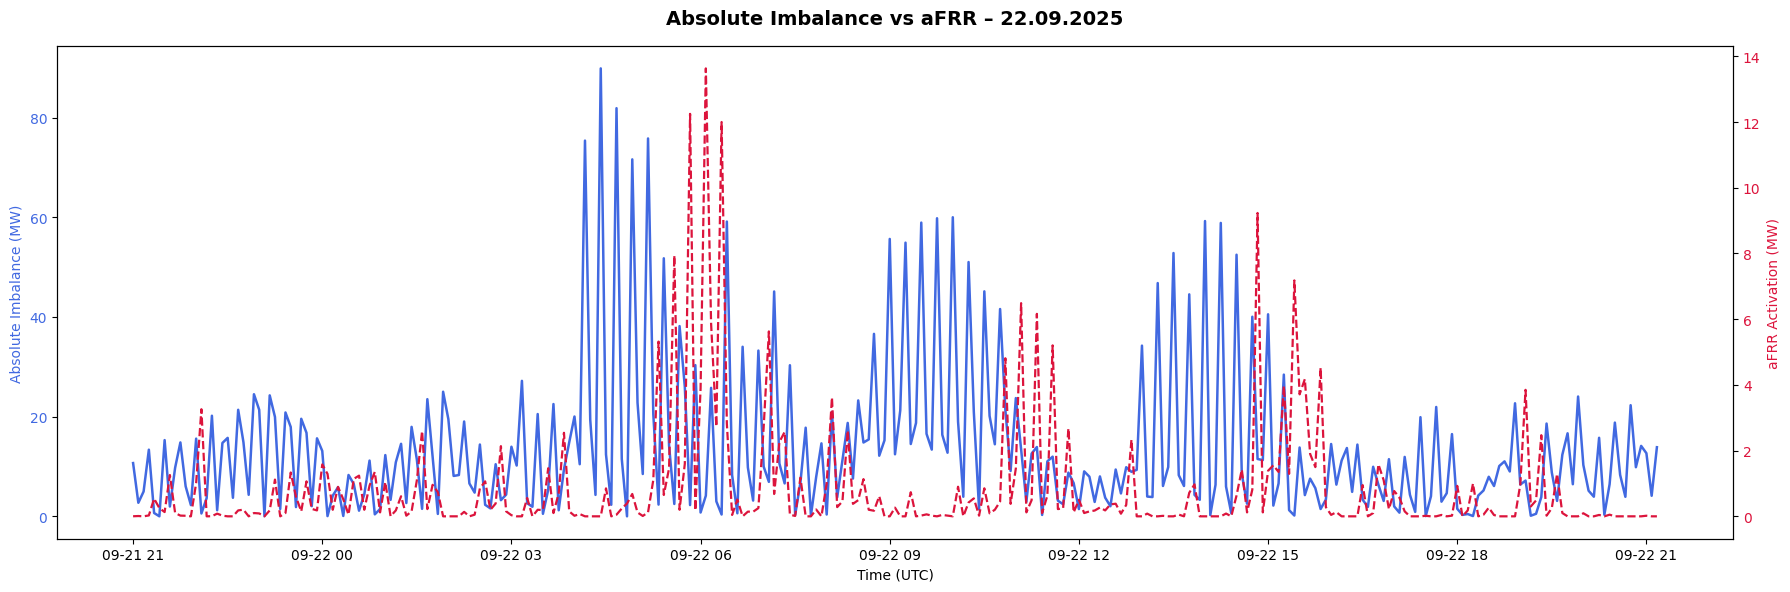

In [21]:
f.plot_abs_imbalance_vs_afrr(
    df,
    title="Absolute Imbalance vs aFRR – 22.09.2025",
    save_path="abs_imbalance_vs_afrr.png"
)

Data is requested and plotted in UTC to avoid time-zone confusion; therefore the local day starting at 00:00 appears as 21:00 on the UTC time axis. For EET time zone its +3 hours.

In [22]:
metrics = f.afrr_assessment_metrics(df)
metrics

,metric,value
0,total_abs_imbalance_MWh,4006.564000
1,total_afrr_activation_MWh,245.625000
2,coverage_ratio_total,0.061306
3,activation_frequency,0.735395
4,"corr(|imbalance|, afrr)",-0.109759
5,active_period_coverage,0.090573
6,peak_abs_imbalance_MWh,89.847000
7,peak_afrr_activation_MWh,13.633000


## aFRR Activation vs System Imbalance – Assessment

The chart shows how aFRR activation behaves compared to the system imbalance over the day.

### What we see in the data
- aFRR is mostly activated when imbalance increases and stays low when the system is close to balance.
- Strong aFRR activation appears during short imbalance peaks, especially in the morning and midday.
- There is no constant activation during calm periods, which means reserves are used only when needed.

### Metrics
- Total imbalance (~4007 MWh) vs aFRR activation (~246 MWh)  
  → aFRR covers only a small share of total imbalance, which is expected.
- Activation frequency (~73%)  
  → aFRR reacts often, showing continuous automatic control.
- Active period coverage (~9%)  
  → high activation happens in short time windows, not all day.
- Peak values (|imbalance| ~90 MWh, aFRR ~14 MWh)  
  → aFRR helps reduce peaks but does not fully eliminate them.
- Low correlation between imbalance and aFRR 
  → normal behaviour, as activation depends on timing, limits, and system response.

### Conclusion
The results show that aFRR was used correctly and efficiently: it reacts quickly to imbalance events, supports the system during critical moments, and avoids unnecessary activation when the system is stable.


# TASK2

### 1. What is the total production capacity of the generators in the model? What is each generating unit power factor? 

In [23]:
tree = f.load_xml_tree("data/20210325T1530Z_1D_NL_EQ_001.xml")
df_units = f.get_generating_units_q1(tree)
df_units




,GeneratingUnit,MaxOperatingP_MW
0,Gen-12908,250.0
1,Gen-12923,1000.0
2,Gen-12910,250.0


In [24]:
df_units["MaxOperatingP_MW"].dropna().sum()

np.float64(1500.0)

### 2.	What kind of regulation control generator NL-G1 has? Why this and do you know any other kinds?

In [25]:
reg_nl_g1 = f.get_generator_regulation_q2(tree, "NL-G1")
reg_nl_g1

{'Generator': 'NL-G1',
 'VoltageRegulationRange': 0.0,
 'RegulatingControlRef': '#_04f338d3-3c0d-433f-a77b-e36dd256f0f0',
 'MachineType': 'http://iec.ch/TC57/CIM100#SynchronousMachineKind.generator'}

#### NL-G1 is a synchronous generator (SynchronousMachineKind.generator) that operates with voltage regulation, while other generators may use reactive power, active power, or Voltage control.

### 3.	What are the nominal voltages of the windings of the transformer NL_TR2_2 (ID: _2184f365-8cd5-4b5d-8a28-9d68603bb6a4)? What type of transformer is this in the grid? 

In [26]:
windings = f.get_transformer_windings_q3(
    tree,
    "_2184f365-8cd5-4b5d-8a28-9d68603bb6a4"
)

windings

[{'EndNumber': None, 'NominalVoltage_kV': None},
 {'EndNumber': None, 'NominalVoltage_kV': None},
 {'EndNumber': None, 'NominalVoltage_kV': None},
 {'EndNumber': None, 'NominalVoltage_kV': 15.75}]

####
 One Winding: nominal voltage 15.75 kV

Other windings: nominal voltage not specified in EQ profile

Multi-winding transformer

### 4.	What is permanently allowed limit for line segment NL-Line_5 (ID: _e8acf6b6-99cb-45ad-b8dc-16c7866a4ddc ) and temporarily allowed. What is difference between those limits. List other types of limits in the grid

In [27]:
limits = f.get_line_limits_q4(
    tree,
    "_e8acf6b6-99cb-45ad-b8dc-16c7866a4ddc"
)

limits


[]

In [28]:
limit_elements = f.find_limit_elements(tree)
limit_elements

['CurrentLimit',
 'CurrentLimit.normalValue',
 'OperationalLimit.OperationalLimitSet',
 'OperationalLimit.OperationalLimitType',
 'OperationalLimitSet',
 'OperationalLimitSet.Terminal',
 'OperationalLimitType',
 'OperationalLimitType.acceptableDuration',
 'OperationalLimitType.direction',
 'OperationalLimitType.isInfiniteDuration',
 'OperationalLimitType.kind',
 'VoltageLevel.highVoltageLimit',
 'VoltageLevel.lowVoltageLimit']

####
- For NL-Line_5, ID: _e8acf6b6-99cb-45ad-b8dc-16c7866a4ddc segment no permanent or temporary operational limits are defined in the provided EQ profile, as no OperationalLimitSet or CurrentLimit objects are linked to this line segment.
- Based on XML extarcted elements it  shows that the grid contains current limits and voltage limits in addition to operational limit classifications.

### 5.	Which generator is set as slack in the model? Why does model need slack node?

In [29]:
slack_gen = f.get_slack_generator_q5(tree)
slack_gen

'No SynchronousMachine.referencePriority attribute defined in this EQ profile.'

### 6.	Find mistakes in the model (both semantic, power system related and logical errors are present)

In [30]:
issues = f.check_model_issues_q6(tree)
issues

[{'Type': 'Logical',
  'Issue': 'Generator without regulating control',
  'Object': 'NL-G3'},
 {'Type': 'Parameter',
  'Issue': 'Generator has zero voltage regulation range',
  'Object': 'NL-G3'},
 {'Type': 'Parameter',
  'Issue': 'Generator has zero voltage regulation range',
  'Object': 'NL-G1'},
 {'Type': 'Logical',
  'Issue': 'Generator without regulating control',
  'Object': 'NL-G2'},
 {'Type': 'Parameter',
  'Issue': 'Generator has zero voltage regulation range',
  'Object': 'NL-G2'},
 {'Type': 'Logical',
  'Issue': 'Terminal without TopologicalNode',
  'Object': '_50f00b94-fe0f-48fd-887e-f0d4d59eee87'},
 {'Type': 'Logical',
  'Issue': 'Terminal without TopologicalNode',
  'Object': '_0f199d49-0093-4b51-b357-70371424d174'},
 {'Type': 'Logical',
  'Issue': 'Terminal without TopologicalNode',
  'Object': '_421c7930-64c3-435d-afb8-2bb73b333e34'},
 {'Type': 'Logical',
  'Issue': 'Terminal without TopologicalNode',
  'Object': '_31bf04d0-7e34-465b-95a4-0604700325cf'},
 {'Type': 'Logi

- From Q2 NL-G1 VoltageRange = 0
- Q3 Other windings: nominal voltage not specified in EQ profile
- Q4 For NL-Line_5, ID: _e8acf6b6-99cb-45ad-b8dc-16c7866a4ddc segment no permanent or temporary operational limits are defined in the provided EQ profile, as no OperationalLimitSet or CurrentLimit objects are linked to this line segment.
- Q5 'No SynchronousMachine.referencePriority attribute defined in this EQ profile.'
